In [ ]:
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt

from covid_model_deaths.data import get_input_data

import warnings
warnings.simplefilter('ignore')

# # DCR_FILE = '/home/j/temp/reed/misc/data_dcr_lag8.csv'
# DCR_FILE = '/home/j/temp/reed/misc/data_dcr_lag8_all_locs_deaths_gte10_v3.csv'
# DCR_MEAN_FILE = '/home/j/temp/reed/misc/data_dcr_lag8_overall_mean_v3.csv'


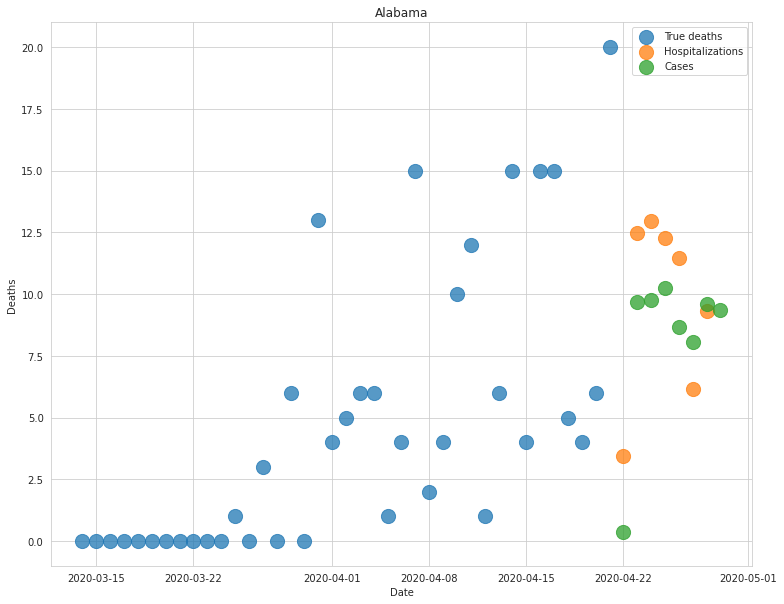

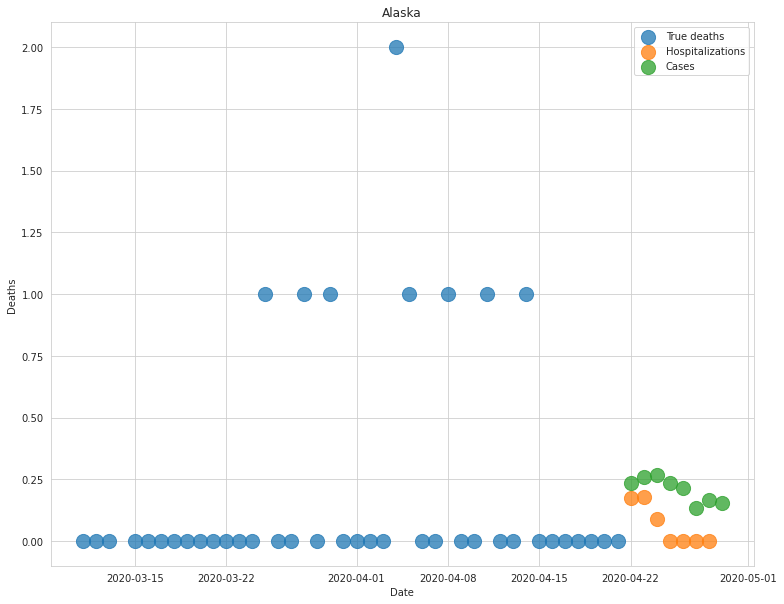

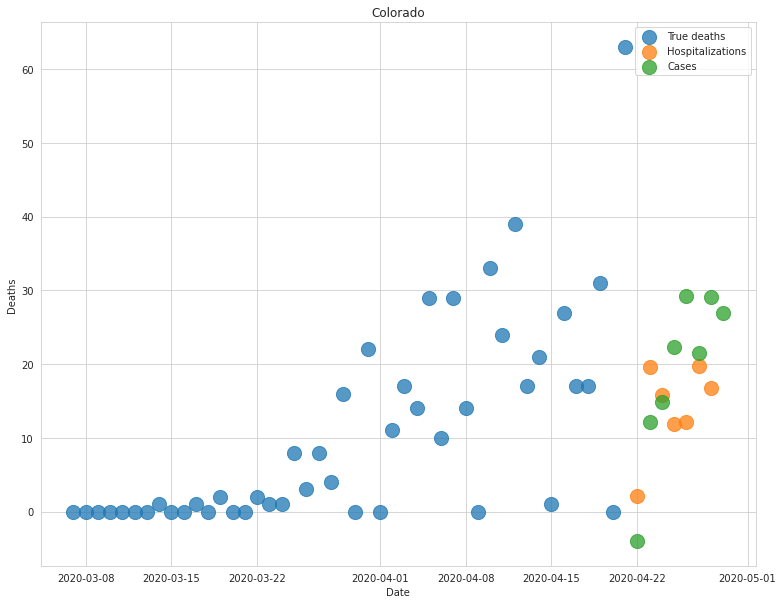

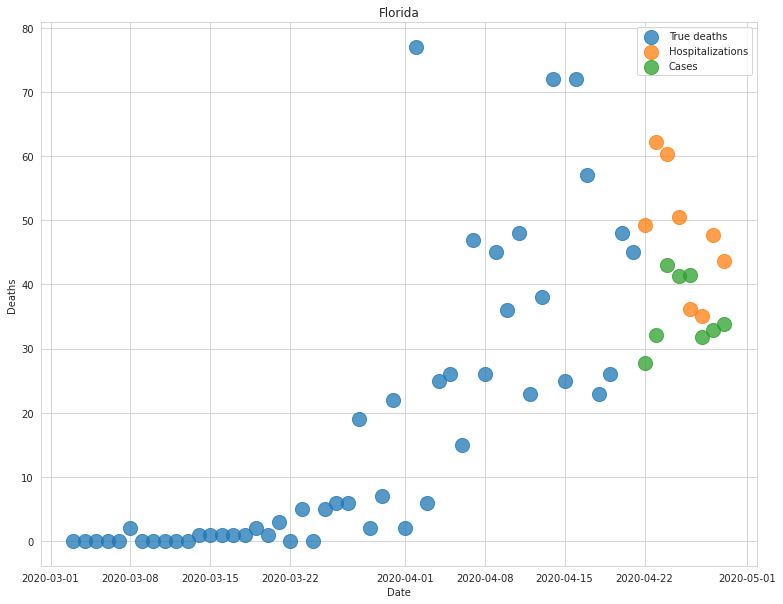

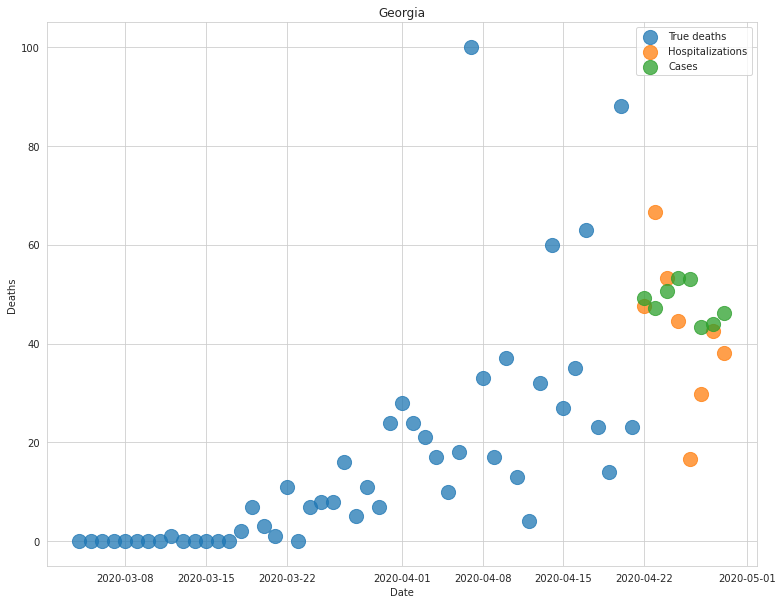

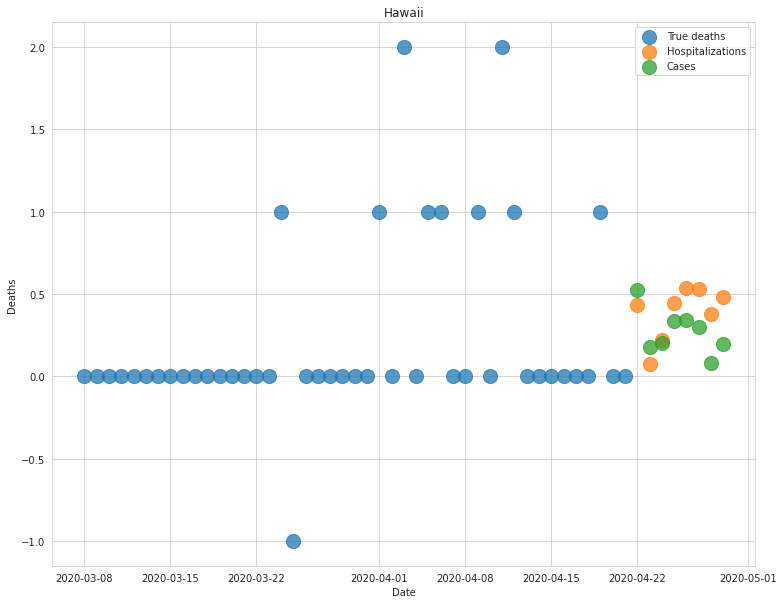

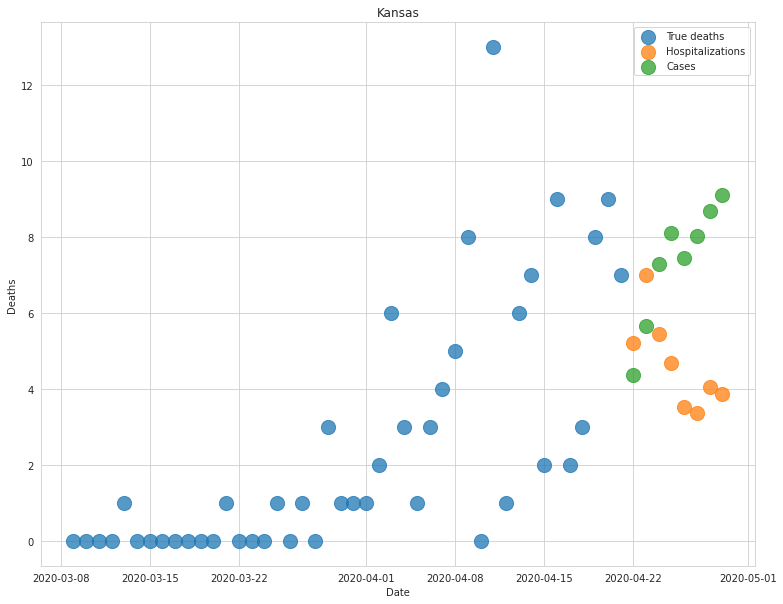

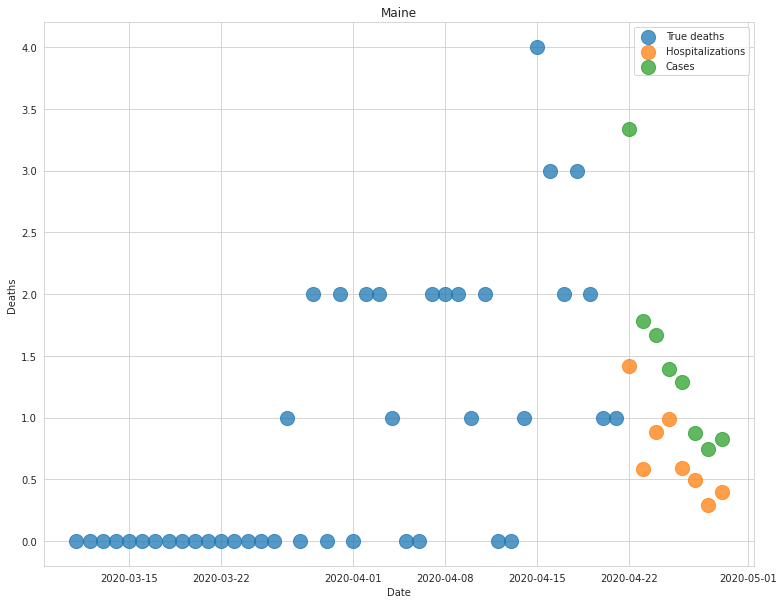

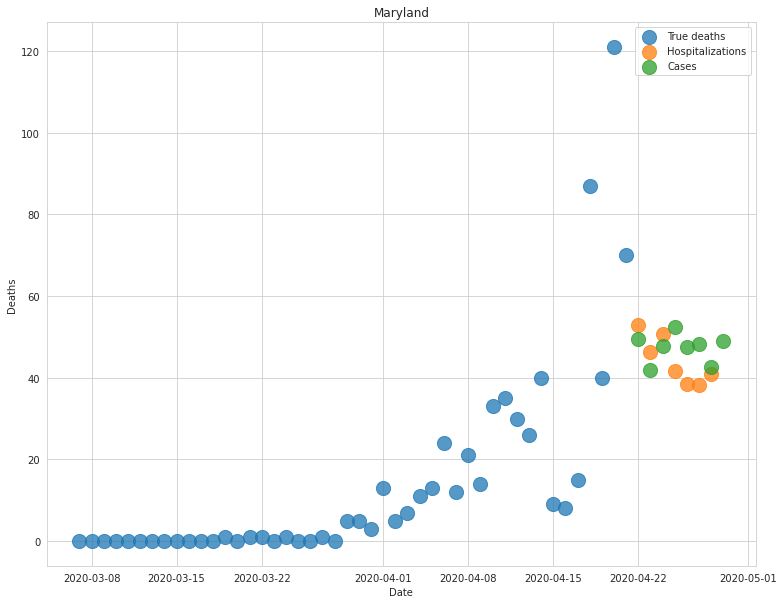

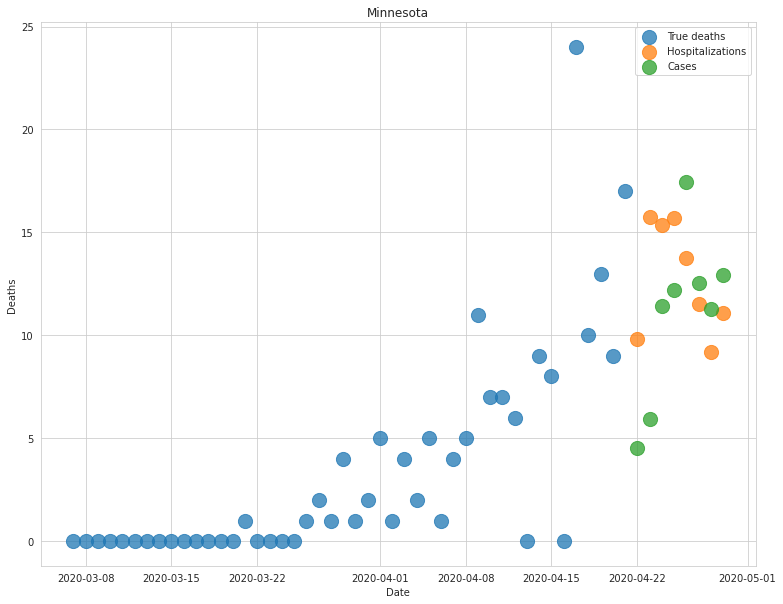

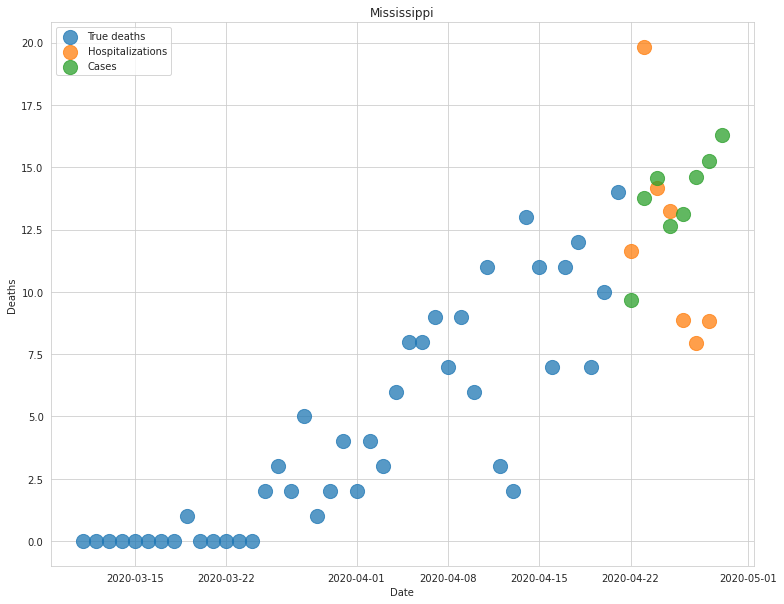

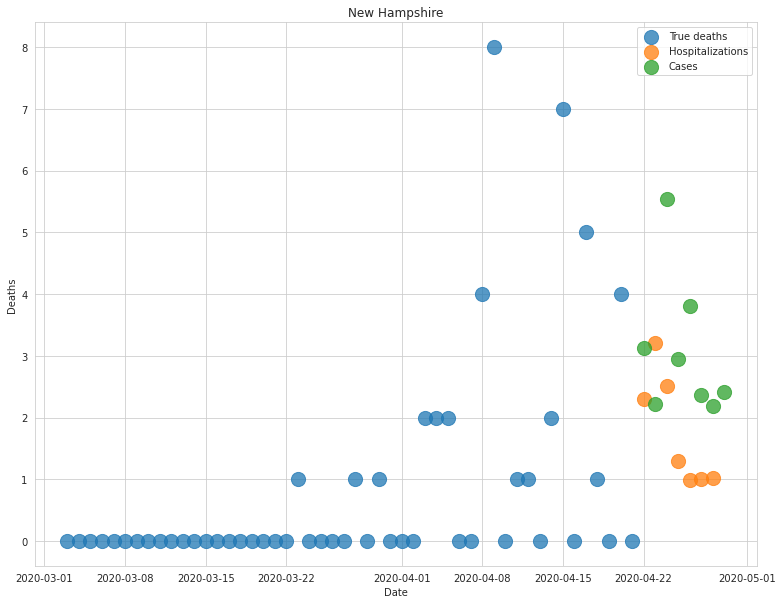

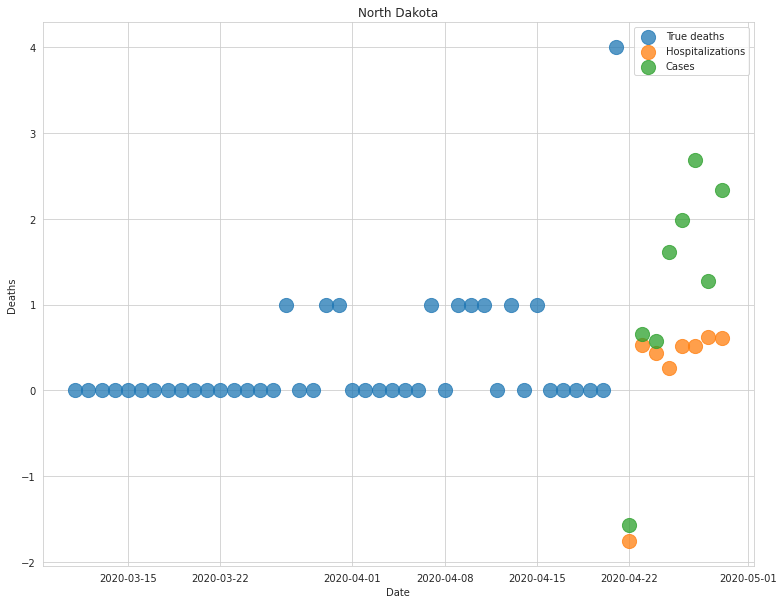

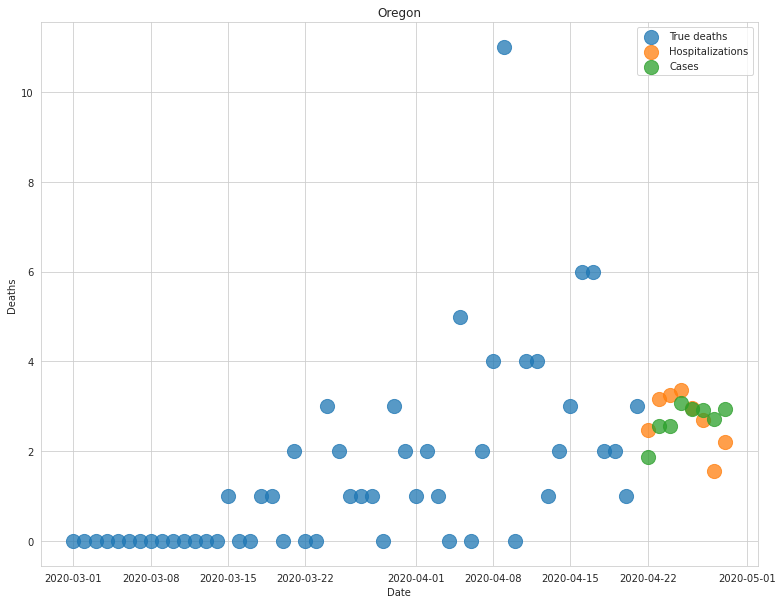

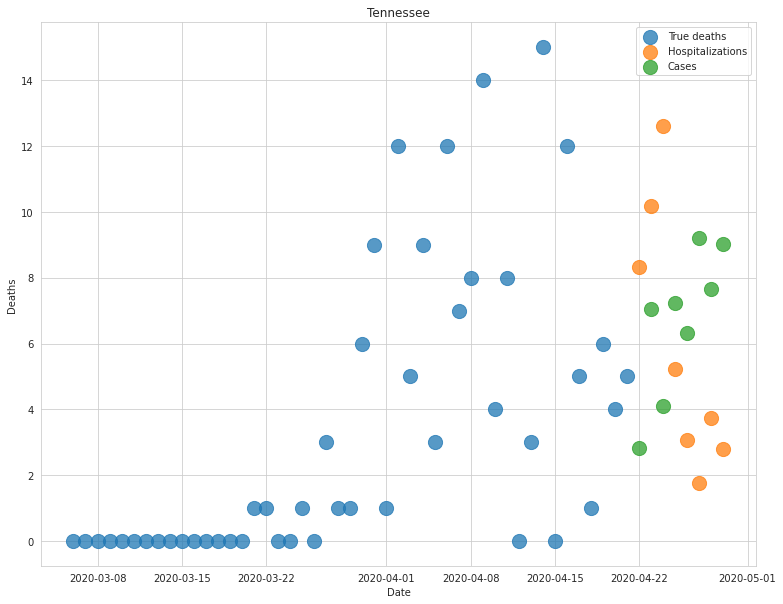

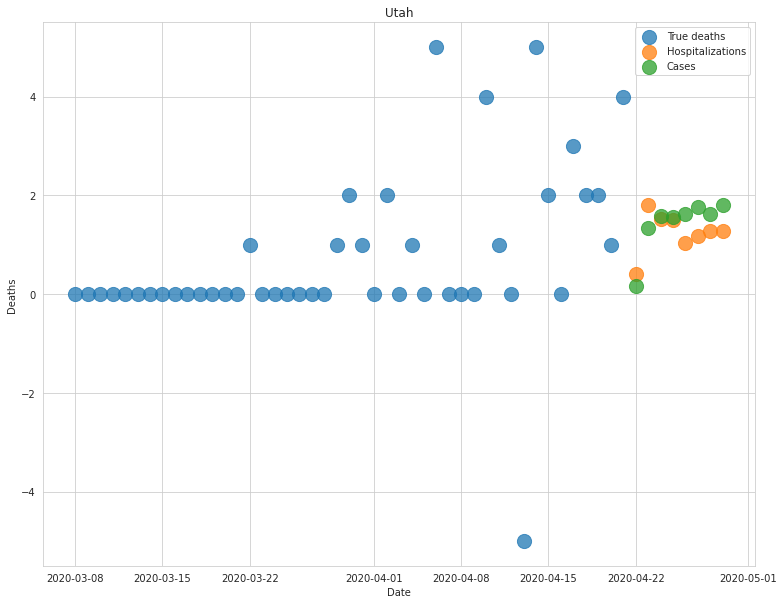

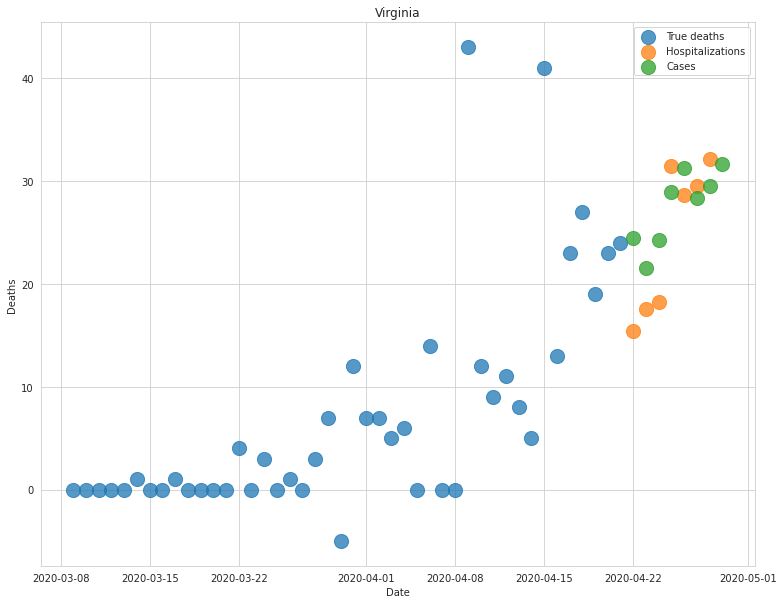

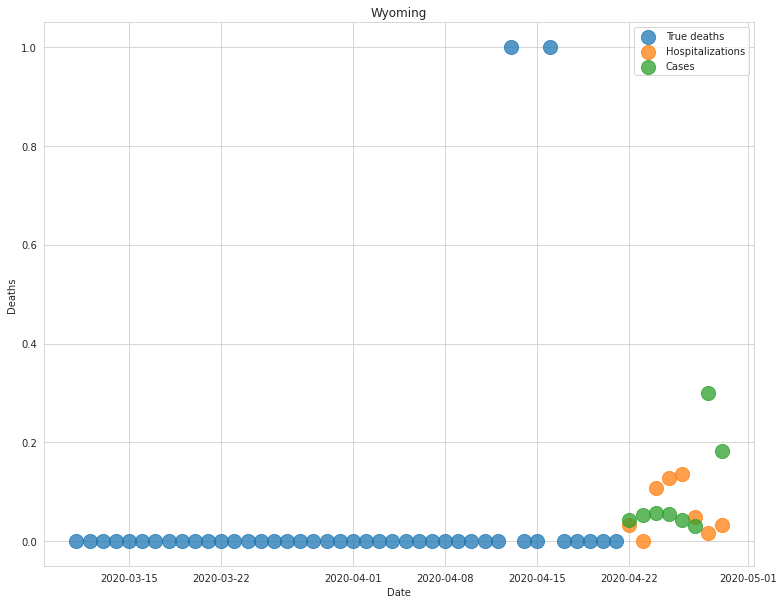

In [15]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

loc_df = get_input_data('full_data')
loc_df['from_cases'] = loc_df['Death rate']
loc_df['from_hospital'] = loc_df['Death rate']
loc_df['pseudo'] = 0

df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_20_US/leading_indicator.csv')
df['from_cases'] = np.exp(df['from_cases'])
df['from_hospital'] = np.exp(df['from_hospital'])
df['Date'] = pd.to_datetime(df['Date'])
df['pseudo'] = 1

df = loc_df[['location_id', 'Date', 'from_cases', 'from_hospital']].append(df)
df = df.merge(loc_df[['location_id', 'population']].drop_duplicates())
df['from_cases'] = df['from_cases'] * df['population']
df['from_hospital'] = df['from_hospital'] * df['population']
df = df.sort_values(['location_id', 'Date']).reset_index(drop=True)
df['from_cases'][1:] = df['from_cases'][1:].values - df['from_cases'][:-1].values
df['from_hospital'][1:] = df['from_hospital'][1:].values - df['from_hospital'][:-1].values
df = df.loc[df['pseudo'] == 1]

loc_df = loc_df.sort_values(['location_id', 'Date']).reset_index(drop=True)
loc_df['Deaths'][1:] = loc_df['Deaths'][1:].values - loc_df['Deaths'][:-1].values
loc_df['day0'] = loc_df.groupby(['location_id'], as_index=False)['Date'].transform(min)
loc_df = loc_df.loc[loc_df['Date'] != loc_df['day0']]
 
with PdfPages(f'/ihme/covid-19/deaths/dev/2020_04_20_US/leading_indicator_compare.pdf') as pdf:
    for location in df['location_id'].unique():
        if len(df.loc[(df['location_id'] == location) & (~df['from_hospital'].isnull())]) > 0:
            plt.figure(figsize=(11, 8.5))
            plt.scatter(loc_df.loc[loc_df['location_id'] == location, 'Date'], 
                        loc_df.loc[loc_df['location_id'] == location, 'Deaths'],
                        label='True deaths', s=200, alpha=0.75)
            plt.scatter(df.loc[df['location_id'] == location, 'Date'], 
                        df.loc[df['location_id'] == location, 'from_hospital'],
                        label='Hospitalizations', s=200, alpha=0.75)
            plt.scatter(df.loc[df['location_id'] == location, 'Date'], 
                        df.loc[df['location_id'] == location, 'from_cases'],
                        label='Cases', s=200, alpha=0.75)
            plt.title(loc_df.loc[loc_df['location_id'] == location, 'Province/State'].values[0])
            plt.xlabel('Date')
            plt.ylabel('Deaths')
            plt.legend()
            plt.tight_layout()
            pdf.savefig()


In [35]:
hosp_df = pd.read_csv('/ihme/covid-19/snapshot-data/best/covid_onedrive/location time series/locs_with_deaths_hosp_cumulative.csv',
                 encoding='latin1')
hosp_df['Date'] = pd.to_datetime(hosp_df['date'], format='%d.%m.%Y')
hosp_df['location_id'] = hosp_df['location_id'].apply(lambda x: int(x.split('/t')[-1]) if isinstance(x, str) else x)
hosp_df = hosp_df.rename(index=str, columns={'hospitalizations':'Hospitalizations'})
# hosp_df.loc[hosp_df['location_id'] == 533, ['location_id', 'Date', 'Hospitalizations']]
ddf = hosp_df.groupby('location_id', as_index=False)['Date'].max()
ddf['Date'].value_counts()

2020-04-20    26
2020-04-21    11
2020-04-01     2
2020-04-05     1
2020-04-08     1
Name: Date, dtype: int64

In [16]:
df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_20_US/lagged_death_to_case_ratios.csv')
print(np.percentile(df['dcr lag8'], (2.5, 97.5)))
print(np.percentile(df['dcr lag8'], (10, 90)))
df

[0.01901853 0.20288265]
[0.02872809 0.14915333]


,location_id,dcr lag8
0,-503001,0.036134
1,-503,0.008143
2,11,0.147754
3,13,0.019654
4,16,0.092823
...,...,...
172,60388,0.045824
173,60390,0.030270
174,60391,0.030697
175,60392,0.036449


## Load case data and attach `Days` column for averaging

In [2]:
df = get_input_data('full_data')
df.loc[df['Country/Region'] != 'Georgia']
df.loc[df['Province/State'].isnull(), 'Province/State'] = df['Country/Region']
df['location_id'] = df['location_id'].astype(int)
df = df.rename(index=str, columns={'Province/State':'Location'})
df['day0'] = df.groupby('location_id', as_index=False)['Date'].transform(min)
df['Days'] = df['Date'] - df['day0']
df['Days'] = df['Days'].apply(lambda x: x.days)
df.loc[df['Confirmed case rate'] == 0, 'Confirmed case rate'] = 1e-16
df.loc[df['Death rate'] == 0, 'Death rate'] = 1e-16
df['ln(confirmed case rate)'] = np.log(df['Confirmed case rate'])
df['ln(death rate)'] = np.log(df['Death rate'])
df = df[['location_id', 'Location', 'Country/Region', 'Date', 'Days', 
         'Confirmed', 'Confirmed case rate', 'ln(confirmed case rate)', 
         'Deaths', 'Death rate', 'ln(death rate)', 'population']]
df = df.sort_values(['location_id', 'Date']).reset_index(drop=True)
df.head()


,location_id,Location,Country/Region,Date,Days,Confirmed,Confirmed case rate,ln(confirmed case rate),Deaths,Death rate,ln(death rate),population
0,-503002,"Wuhan City, Hubei",China,2019-12-31,0,27.0,0.000003,-12.769369,0.0,1.000000e-16,-36.841361,9.484843e+06
1,-503002,"Wuhan City, Hubei",China,2020-01-03,3,44.0,0.000005,-12.281016,0.0,1.000000e-16,-36.841361,9.484843e+06
2,-503002,"Wuhan City, Hubei",China,2020-01-05,5,59.0,0.000006,-11.987668,0.0,1.000000e-16,-36.841361,9.484843e+06
3,-503002,"Wuhan City, Hubei",China,2020-01-10,10,41.0,0.000004,-12.351634,1.0,1.054314e-07,-16.065206,9.484843e+06
4,-503002,"Wuhan City, Hubei",China,2020-01-11,11,41.0,0.000004,-12.351634,1.0,1.054314e-07,-16.065206,9.484843e+06


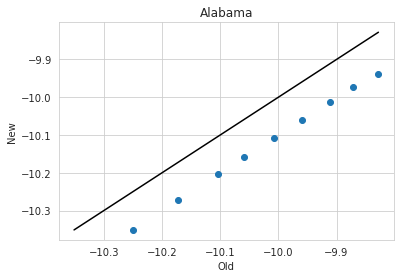

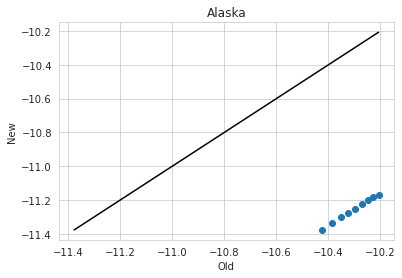

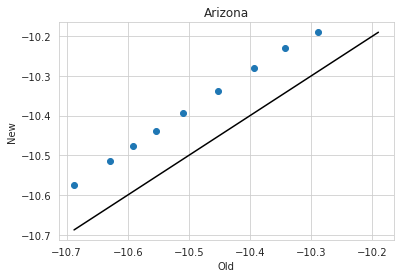

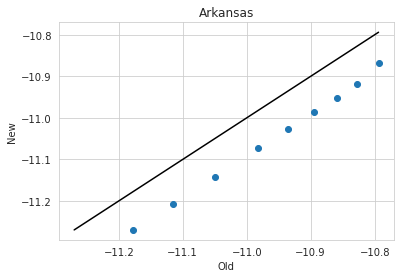

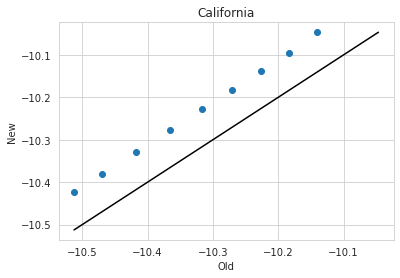

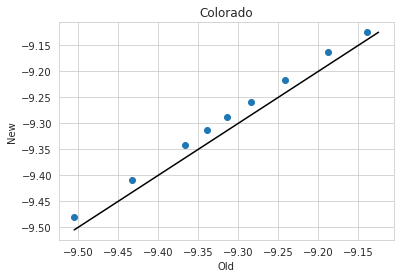

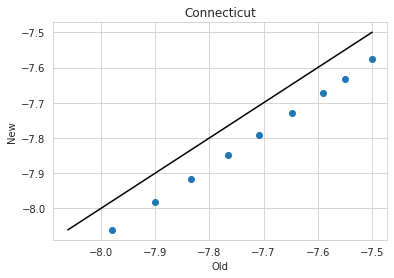

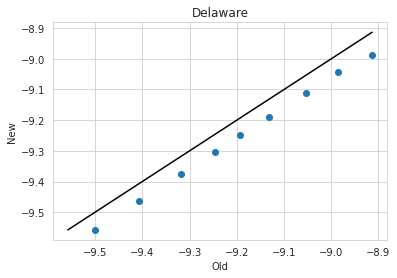

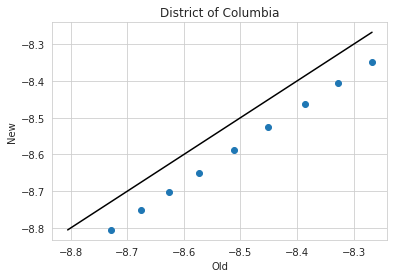

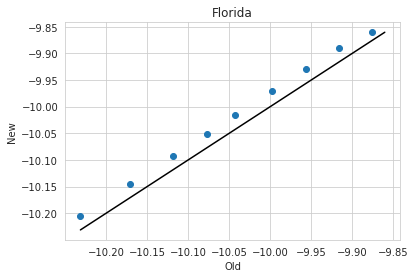

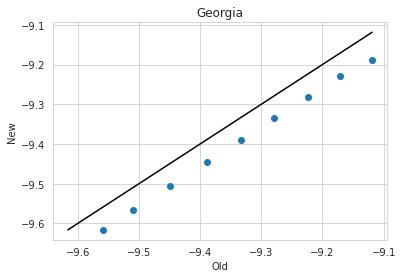

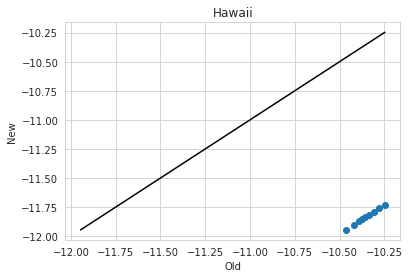

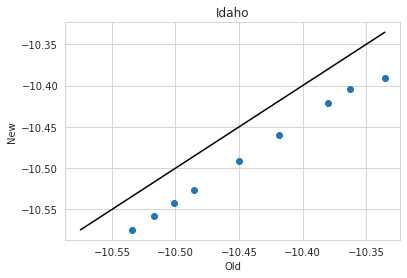

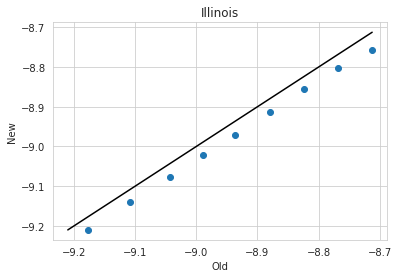

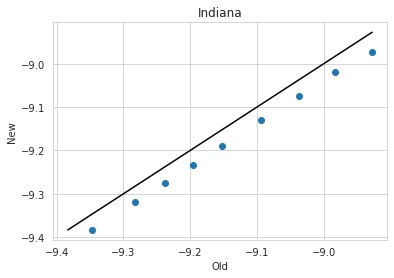

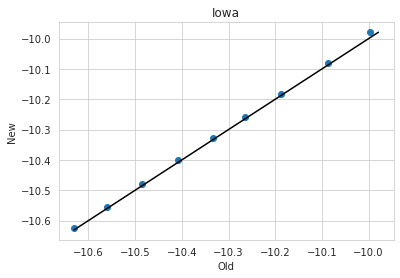

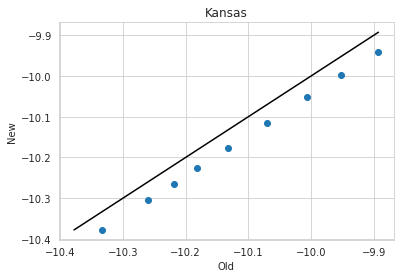

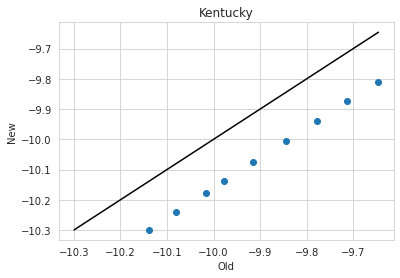

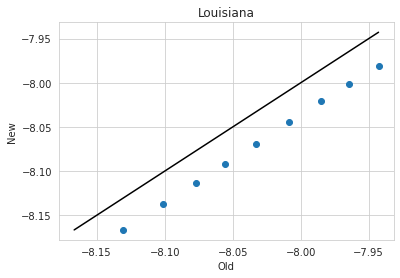

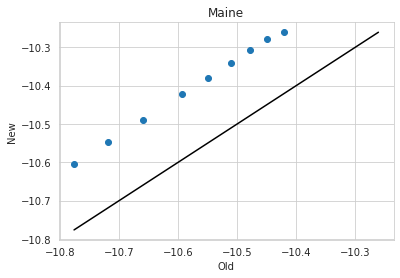

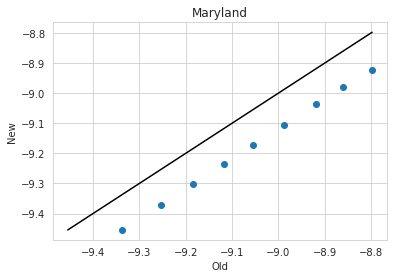

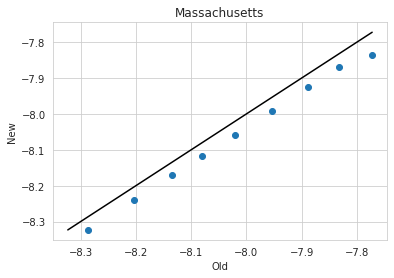

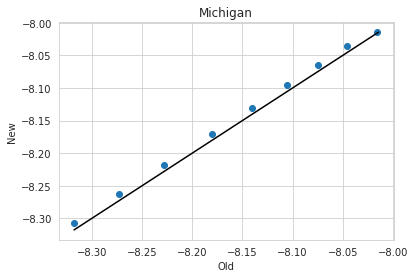

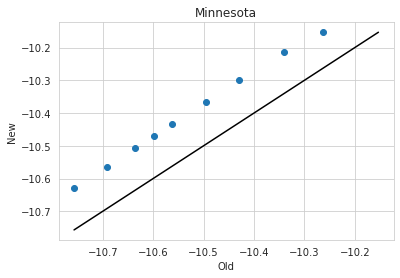

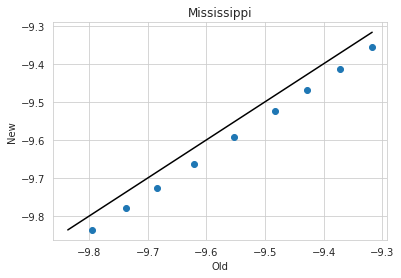

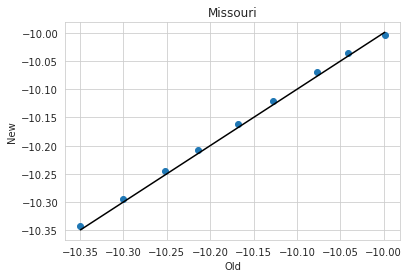

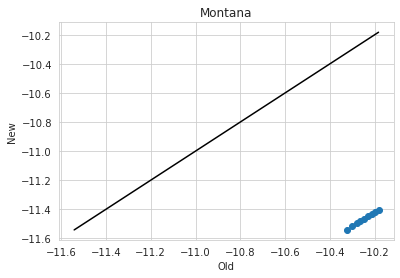

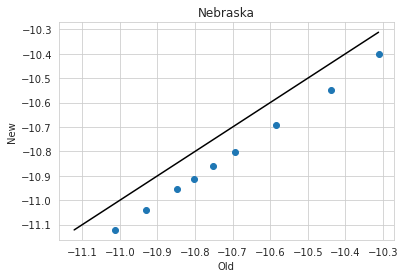

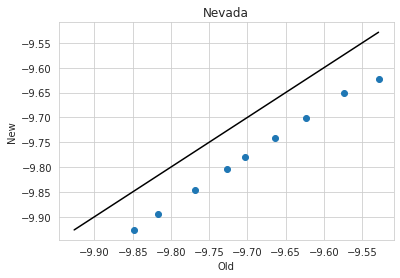

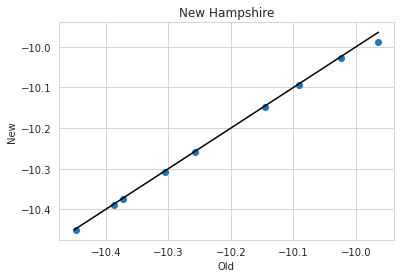

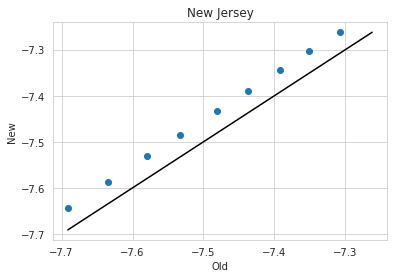

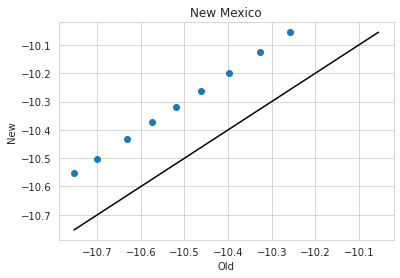

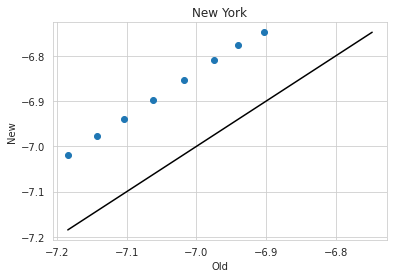

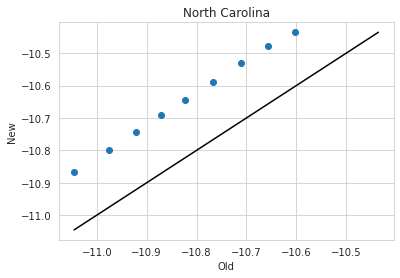

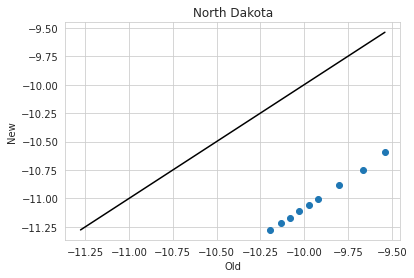

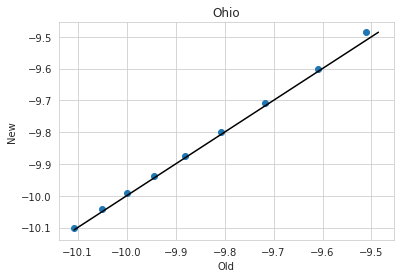

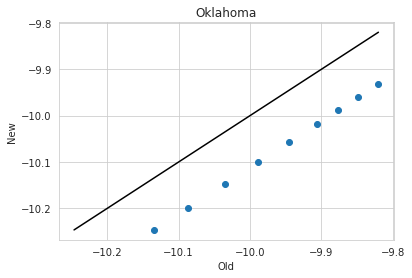

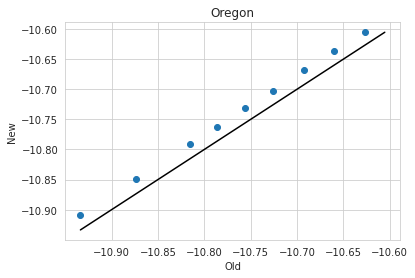

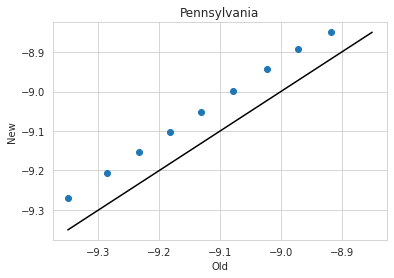

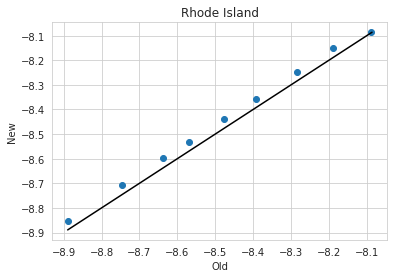

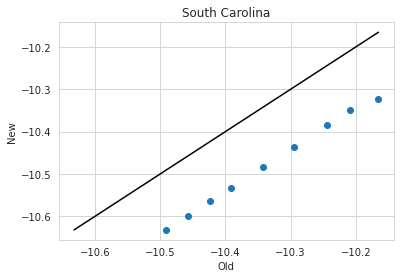

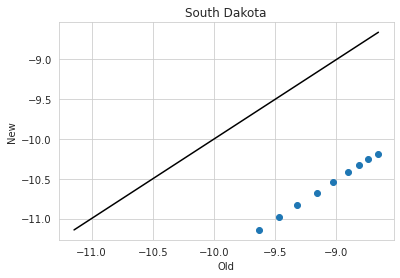

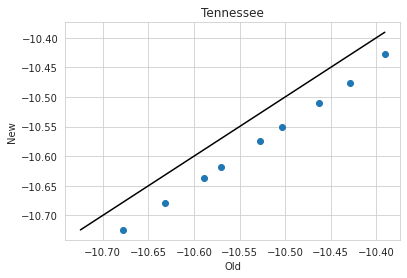

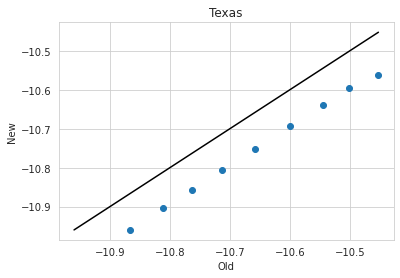

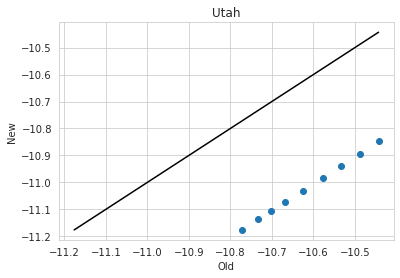

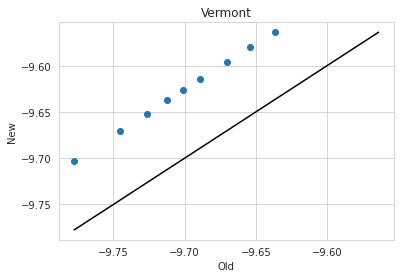

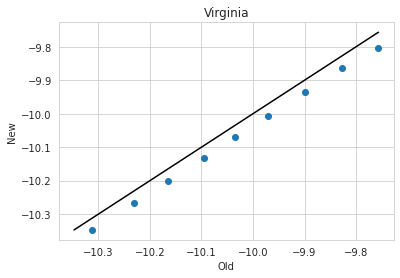

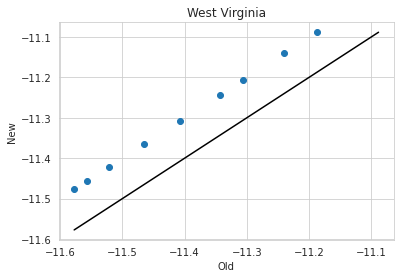

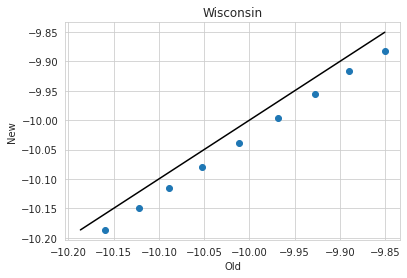

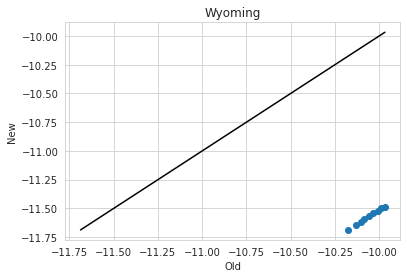

In [32]:
old_df = pd.read_csv('/ihme/covid-19/deaths/mobility_inputs/2020_04_20/deaths_from_cases.csv')
old_df = old_df.rename(index=str, columns={'ln(age-standardized death rate)':'old_rate'})
new_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_20_US/leading_indicator.csv')
new_df = new_df.rename(index=str, columns={'ln(age-standardized death rate)':'new_rate'})
df = old_df.merge(new_df)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] >= pd.Timestamp('2020-04-19')]

for location in df['Location'].unique().tolist():
    min_rate = df.loc[df['Location'] == location, ['new_rate', 'old_rate']].values.min()
    max_rate = df.loc[df['Location'] == location, ['new_rate', 'old_rate']].values.max()
    plt.scatter(df.loc[df['Location'] == location, 'old_rate'], 
                df.loc[df['Location'] == location, 'new_rate'])
    plt.plot((min_rate, max_rate), (min_rate, max_rate), color='black')
    plt.title(location)
    plt.xlabel('Old')
    plt.ylabel('New')
    plt.show()

## get ratio of deaths to cases 8-days prior

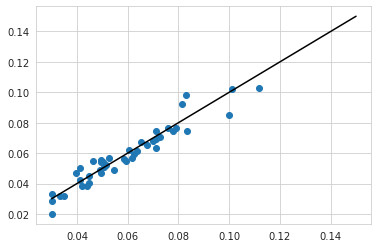

In [31]:
# case_df = df[['location_id', 'Location', 'Country/Region', 'Date', 'Confirmed']]
# case_df['Date'] = case_df['Date'].apply(lambda x: x + timedelta(days=8))
# dcr_df = df[['location_id', 'Location', 'Country/Region', 'Date', 'Deaths']].merge(case_df)
# dcr_df['dcr'] = dcr_df['Deaths'] / dcr_df['Confirmed']
# dcr_df['latest_date'] = dcr_df.groupby('location_id', as_index=False)['Date'].transform(max)
# date_cols = ['latest_date']
# for i in range(1, 4):
#     dcr_df[f'latest_date_sub{i}'] = dcr_df['latest_date'].apply(lambda x: x - timedelta(days=i))
#     date_cols.append(f'latest_date_sub{i}')
# dcr_df = dcr_df.loc[dcr_df['Confirmed'] > 0]

# # option 1 - use last day
# dcr_df = dcr_df = dcr_df.loc[dcr_df['Date'] == dcr_df['latest_date']]

# # # option 2 - average last three days
# # dcr_df = dcr_df.loc[dcr_df['Date'] >= dcr_df['latest_date_sub3']]
# # dcr_df = dcr_df.groupby(['location_id', 'Location', 'Country/Region'], as_index=False)['dcr', 'Deaths'].mean()

dcr_old = pd.read_csv('/home/j/temp/reed/misc/data_dcr_lag8_all_locs_deaths_gte10_v3.csv')
dcr_old = dcr_old.rename(index=str, columns={'dcr_lag8':'old_dcr'})
dcr_old = dcr_old[['location_id', 'Province.State', 'Country.Region', 'old_dcr']]

dcr_new = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_20_US/lagged_death_to_case_ratios.csv')
dcr_new['location_id'] = dcr_new['location_id'].astype(int)
dcr_new = dcr_new.rename(index=str, columns={'dcr lag8':'new_dcr'})

dcr_df = dcr_old[['location_id', 'Province.State', 'Country.Region', 'old_dcr']].merge(
    dcr_new
)


plt.scatter(dcr_df['old_dcr'], dcr_df['new_dcr'])
plt.plot((0.03, 0.15), (0.03, 0.15), color='black')
plt.show()

# fig, ax = plt.subplots(2, 2, figsize=(20, 12))

# # all data
# for n_deaths in [0, 5, 10]:
#     ax[0,0].hist(dcr_df.loc[(dcr_df['Deaths'] > n_deaths), 'dcr'],
#                  bins=50, label=n_deaths)
# ax[0,0].axvline(0.01, linestyle='--', color='black', alpha=0.5)
# ax[0,0].axvline(0.015, linestyle='--', color='black', alpha=0.5)
# ax[0,0].axvline(0.02, linestyle='--', color='black', alpha=0.5)
# ax[0,0].axvline(0.03, linestyle='--', color='black', alpha=0.5)
# ax[0,0].set_title('All data')

# # national
# for n_deaths in [0, 5, 10]:
#     ax[0,1].hist(dcr_df.loc[(dcr_df['Location'] == dcr_df['Country/Region']) &
#                             (dcr_df['Deaths'] > n_deaths), 'dcr'],
#                  bins=50, label=n_deaths)
# ax[0,1].axvline(0.01, linestyle='--', color='black', alpha=0.5)
# ax[0,1].axvline(0.015, linestyle='--', color='black', alpha=0.5)
# ax[0,1].axvline(0.02, linestyle='--', color='black', alpha=0.5)
# ax[0,1].axvline(0.03, linestyle='--', color='black', alpha=0.5)
# ax[0,1].set_title('National only')
# ax[0,1].legend()

# # subnational
# for n_deaths in [0, 5, 10]:
#     ax[1,0].hist(dcr_df.loc[(dcr_df['Location'] != dcr_df['Country/Region']) &
#                             (dcr_df['Deaths'] > n_deaths), 'dcr'],
#                  bins=50, label=n_deaths)
# ax[1,0].axvline(0.01, linestyle='--', color='black', alpha=0.5)
# ax[1,0].axvline(0.015, linestyle='--', color='black', alpha=0.5)
# ax[1,0].axvline(0.02, linestyle='--', color='black', alpha=0.5)
# ax[1,0].axvline(0.03, linestyle='--', color='black', alpha=0.5)
# ax[1,0].set_title('Subnational only')

# # US
# for n_deaths in [0, 5, 10]:
#     ax[1,1].hist(dcr_df.loc[(dcr_df['Country/Region'] == 'United States of America') &
#                             (dcr_df['Deaths'] > n_deaths), 'dcr'],
#              bins=25, label=n_deaths)
# ax[1,1].axvline(0.01, linestyle='--', color='black', alpha=0.5)
# ax[1,1].axvline(0.015, linestyle='--', color='black', alpha=0.5)
# ax[1,1].axvline(0.02, linestyle='--', color='black', alpha=0.5)
# ax[1,1].axvline(0.03, linestyle='--', color='black', alpha=0.5)
# ax[1,1].set_title('US')
# plt.tight_layout()
# plt.show()


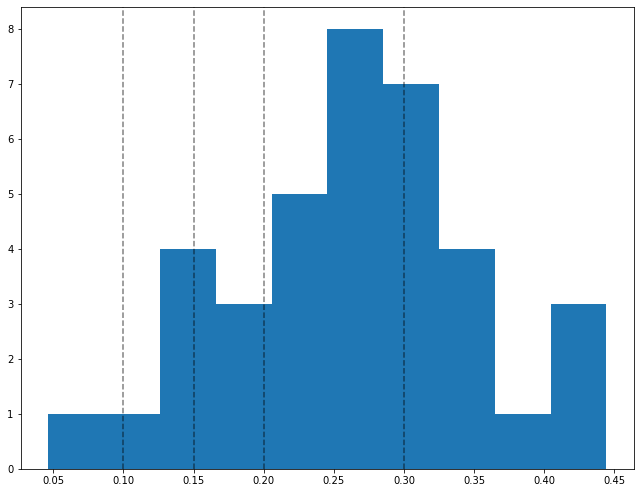

,location_id,dhr lag8
0,523.0,0.394054
1,524.0,0.257244
2,528.0,0.314019
3,532.0,0.299838
4,533.0,0.296057
5,534.0,0.253069
6,539.0,0.345681
7,542.0,0.315840
8,543.0,0.311603
9,546.0,0.440645


In [5]:
import matplotlib.pyplot as plt
dhr_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_23_Europe_gm_17/lagged_death_to_hosp_ratios.csv')

# all data
plt.figure(figsize=(11, 8.5))
plt.hist(dhr_df['dhr lag8'], bins=10)
plt.axvline(0.1, linestyle='--', color='black', alpha=0.5)
plt.axvline(0.15, linestyle='--', color='black', alpha=0.5)
plt.axvline(0.2, linestyle='--', color='black', alpha=0.5)
plt.axvline(0.3, linestyle='--', color='black', alpha=0.5)
plt.show()

dhr_df

## Do averaging

In [3]:
def _moving_average_cases(df, smooth_var):
    if df.location_id.unique().size != 1:
        raise ValueError('Multiple locations in dataset.')
    if df['Days'].min() != 0:
        raise ValueError('Not starting at 0')
    df = df.merge(pd.DataFrame({'Days': np.arange(df['Days'].min(), df['Days'].max()+1)}), how='outer')
    df = df.sort_values('Days').reset_index(drop=True)
    df.loc[df['Date'].isnull(), 'Date'] = (df.loc[df['Date'].isnull(), 'Days']
                                           .apply(lambda x: df['Date'].min() + timedelta(days=x)))
    # TODO: Document.
    df = df.fillna(method='pad')
    df['location_id'] = df['location_id'].astype(int)

    # FIXME: Shadowing variable from outer scope.  Make a separate
    #  function.
    def moving_3day_avg(day, df, measure):
        # determine difference
        days = np.array([day-1, day, day+1])
        days = days[days >= 0]
        days = days[days <= df['Days'].max()]
        avg = df.loc[df['Days'].isin(days), measure].mean()

        return avg

    # get diffs
    avgs = [moving_3day_avg(i, df, smooth_var) for i in df['Days']]
    df[f'Observed {smooth_var}'] = df[smooth_var]
    df[smooth_var] = avgs

    # replace last point w/ daily value over 3->2 and 2->1 and the first
    # with 1->2, 2->3; use observed if 3 data points or less
    if len(df) > 3:
        last_step = np.mean(np.array(avgs[-3:-1]) - np.array(avgs[-4:-2]))
        df[smooth_var][len(df)-1] = (df[smooth_var][len(df)-2]
                                                            + last_step)
        first_step = np.mean(np.array(avgs[2:4]) - np.array(avgs[1:3]))
        df[smooth_var][0] = df[smooth_var][1] - first_step
    else:
        df[smooth_var] = df[f'Observed {smooth_var}']

    return df
loc_dfs = [df.loc[df['location_id'] == l].reset_index(drop=True) for l in df.location_id.unique()]
loc_df = pd.concat([_moving_average_cases(loc_df, 'ln(confirmed case rate)') for loc_df in loc_dfs])
loc_df = loc_df.loc[~loc_df['ln(confirmed case rate)'].isnull()]
loc_df.head()


/ihme/code/covid-19/deaths/conda/miniconda3/envs/covid_dev_2020_04_12/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/ihme/code/covid-19/deaths/conda/miniconda3/envs/covid_dev_2020_04_12/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,location_id,Location,Country/Region,Date,Days,ln(confirmed case rate),population,Observed ln(confirmed case rate)
0,-503002,"Wuhan City, Hubei",China,2019-12-31,0,-12.932153,9.484843e+06,-12.769369
1,-503002,"Wuhan City, Hubei",China,2020-01-01,1,-12.769369,9.484843e+06,-12.769369
2,-503002,"Wuhan City, Hubei",China,2020-01-02,2,-12.606584,9.484843e+06,-12.769369
3,-503002,"Wuhan City, Hubei",China,2020-01-03,3,-12.443800,9.484843e+06,-12.281016
4,-503002,"Wuhan City, Hubei",China,2020-01-04,4,-12.183233,9.484843e+06,-12.281016


## get reads data and use it to produce deaths from smoothed cases
#### call it ln(asdr) just to make it compatible with data we will have in death model

In [4]:
# location-specific dataset
dcr_df = pd.read_csv(DCR_FILE)
dcr_df = dcr_df.loc[dcr_df['Country.Region'] != 'Georgia']
dcr_df = dcr_df[['location_id', 'dcr_lag8']]

# use average for all locations that don't have specific
dcr_mean_df = pd.read_csv(DCR_MEAN_FILE)
for location_id in [i for i in loc_df['location_id'].unique() if i not in dcr_df['location_id'].to_list()]:
    _dcr_df = dcr_mean_df.copy()
    _dcr_df['location_id'] = location_id
    dcr_df = dcr_df.append(_dcr_df[['location_id', 'dcr_lag8']])
dcr_df = dcr_df.reset_index(drop=True)

# manually fix Iceland (this is their ratio on 04/16)
dcr_df.loc[dcr_df['location_id'] == 83, 'dcr_lag8'] = 8.0 / 1616.0

death_df = loc_df.merge(dcr_df[['location_id', 'dcr_lag8']])
death_df['Confirmed case rate'] = np.exp(death_df['ln(confirmed case rate)'])
death_df['Death rate'] = death_df['Confirmed case rate'] * death_df['dcr_lag8']
death_df['ln(age-standardized death rate)'] = np.log(death_df['Death rate'])

# shift data forward 8 days
death_df['Date'] = death_df['Date'].apply(lambda x: x + timedelta(days=8))
death_df = death_df[['location_id', 'Location', 'Country/Region', 'Date', 'ln(age-standardized death rate)']]

# save data
death_df.to_csv('/ihme/covid-19/deaths/mobility_inputs/2020_04_14/deaths_from_cases.csv', index=False)
death_df.head()


,location_id,Location,Country/Region,Date,ln(age-standardized death rate)
0,-503002,"Wuhan City, Hubei",China,2020-01-08,-15.896934
1,-503002,"Wuhan City, Hubei",China,2020-01-09,-15.734150
2,-503002,"Wuhan City, Hubei",China,2020-01-10,-15.571366
3,-503002,"Wuhan City, Hubei",China,2020-01-11,-15.408581
4,-503002,"Wuhan City, Hubei",China,2020-01-12,-15.148015
